<a href="https://colab.research.google.com/github/cjweems/image-filter-project/blob/main/ImageFilterProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
cd drive/MyDrive/'AP CSP'/'Image Filter Project'

/content/drive/MyDrive/AP CSP/Image Filter Project


Would you like to make your face blurred or your body blurred? (f/b): b


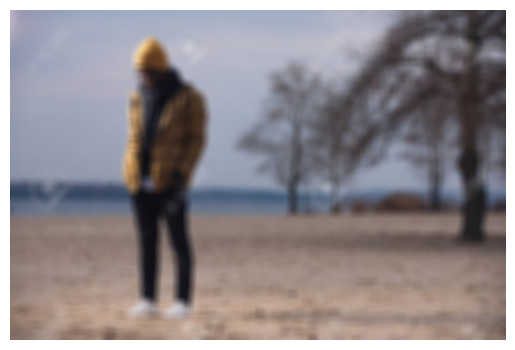

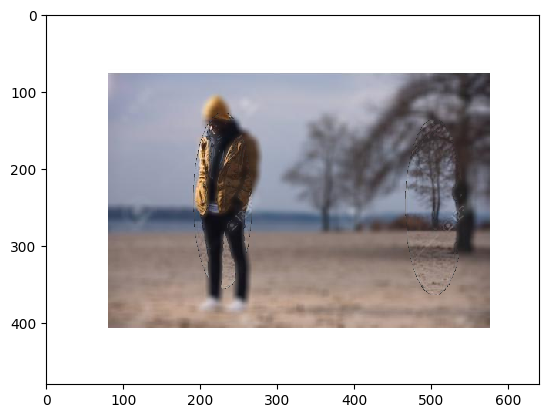

In [21]:
%matplotlib inline
import os
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import PIL
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# Function to take the photo
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

def faceMask():
  # Open the image
  img = cv2.imread('photo.jpg')

  # Gray image
  gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  #Load the pre-trained classifier
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") #Note the change

  # Preform the face detection
  face = face_cascade.detectMultiScale(gray_img,1.1,4)

  # Make the image color
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Mask
  mask = np.zeros(img.shape[:2], dtype="uint8")

  for x,y,width,height in face:
    # Find the center of the face
    corner1 = (x,y)
    corner2 = (x+width, y)
    corner3 = (x, y+height)
    corner4 = (x+width, y+height)
    centerx = (x + (x+width) + x + (x+width)) / 4
    centery = (y + (y+height) + y + (y+height)) / 4

    # Draw the ellipse to fit the face
    center_coordinates = (int(centerx), int(centery))
    axesLength = (100, 150)
    cv2.ellipse(mask, center_coordinates, axesLength, 0, 0, 360, (255, 255, 255), -1)

  # Cut out the circle from the image
  faceMask = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
  plt. axis('off')
  plt.imshow(faceMask)
  plt.savefig("masked.jpg")

  backgroundblur = cv2.blur(img_rgb, (25,25))
  plt. axis('off')
  plt.imshow(backgroundblur)
  plt.savefig("background.jpg")

def blurredFaceBackground():
  faceOverlayFile = Image.open('masked.jpg')
  faceOverlay = faceOverlayFile.convert("RGBA")
  fpixdata = faceOverlay.load()
  fwidth, fheight = faceOverlay.size

  for y in range(fheight):
      for x in range(fwidth):
          if fpixdata[x,y][0] < 50 and fpixdata[x,y][1] < 50 and fpixdata[x,y][2] < 50:
            fpixdata[x, y] = (0,0,0,0)

  Background = Image.open('background.jpg')

  Background.paste(faceOverlay, (0, 0), mask=faceOverlay)

  Background.save("output.png")
  fig, ax = plt.subplots(1, 1, figsize=(12, 10))
  directory = os.getcwd()
  filename_greenscreen = os.path.join(directory, 'output.png')
  img = np.array(Image.open(filename_greenscreen))
  ax.imshow(img, interpolation='none')
  ax.axis('off')
  fig.show()

def bodyMask():
# Open the image
  directory = os.getcwd()
  img = cv2.imread(os.path.join(directory, 'standing.jpg'))

  # Gray image
  gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  #Load the pre-trained classifier
  body_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_fullbody.xml")

  # Preform the face detection
  body = body_cascade.detectMultiScale(gray_img,1.1,4)

  # Make the image color
  img_rgb2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Make the mask
  mask2 = np.zeros(img.shape[:2], dtype="uint8")

  for x,y,width,height in body:
    # Find the center of the body
    corner1 = (x,y)
    corner2 = (x+width, y)
    corner3 = (x, y+height)
    corner4 = (x+width, y+height)

    centerx = (x + (x+width) + x + (x+width)) / 4
    centery = (y + (y+height) + y + (y+height)) / 4

    # Draw the ellipse to fit the face
    center_coordinates = (int(centerx), int(centery))
    axesLength = (100, 300)

    cv2.ellipse(mask2, center_coordinates, axesLength, 0, 0, 360, (255, 255, 255), -1)

  # Cut out the circle from the image
  bodyMask = cv2.bitwise_and(img_rgb2, img_rgb2, mask=mask2)
  plt. axis('off')
  plt.imshow(bodyMask)
  plt.savefig("bodymask1.jpg")

  backgroundblur = cv2.blur(img_rgb2, (25,25))
  plt. axis('off')
  plt.imshow(backgroundblur)
  plt.savefig("bodyBackground.jpg")

def blurredBodyBackground():
  directory = os.getcwd()
  faceOverlayFile = Image.open(os.path.join(directory, 'bodymask1.jpg'))
  faceOverlay = faceOverlayFile.convert("RGBA")
  fpixdata = faceOverlay.load()
  fwidth, fheight = faceOverlay.size

  for y in range(fheight):
      for x in range(fwidth):
          if fpixdata[x,y][0] < 50 and fpixdata[x,y][1] < 50 and fpixdata[x,y][2] < 50:
            fpixdata[x, y] = (0,0,0,0)
  Background = Image.open(os.path.join(directory, 'bodyBackground.jpg'))

  Background.paste(faceOverlay, (0, 0), mask=faceOverlay)

  Background.save("output2.png")
  fig, ax = plt.subplots(1, 1)
  directory = os.getcwd()
  filename_greenscreen = os.path.join('output2.png')
  img = np.array(Image.open(filename_greenscreen))
  ax.imshow(img, interpolation='none')
  fig.show()

def userInput():
  response = input("Would you like to make your face blurred or your body blurred? (f/b): ")

  if response == "f":
    try:
      filename = take_photo()
    except Exception as err:
      print(str(err))
    faceMask()
    blurredFaceBackground()
  elif response == "b":
    bodyMask()
    blurredBodyBackground()
  else:
    userInput()

userInput()